## Fashion Image Classification
#### By X. He

In [ ]:
#Referenced:
#https://keras.io/examples/vision/mnist_convnet/
#https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide
#https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/

In this document, different machine learning algorithms will be used to classify fashion images from Zalando's article provided by Kaggle at https://www.kaggle.com/datasets/zalando-research/fashionmnist. The results and performance of different models will be compared to find out the best model to perform image classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib import rcParams
import seaborn as sb
from pandas import DataFrame

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import HistGradientBoostingClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import timeit

2022-11-26 17:49:25.449532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
images = pd.read_csv("fashion-mnist_train.csv")
print(images.head())
print(images.shape)

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [3]:
#check how many null values are in the data set
sum(images.isnull().sum())

0

### Data Exploration

In [4]:
print(images.describe())

              label        pixel1        pixel2        pixel3        pixel4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000000    226.000000    164.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.247967      0.411467      0.805767      2.198283      5.682000   
std        4.306912      5.836188      8.215169    

In [5]:
print(images['label'].value_counts())

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64


In [6]:
#create a new df that include a new label column that includes the name of each class
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

new_df = pd.DataFrame()
for i in np.arange(0, len(class_names)):
    df = images[images['label'] == i]
    df.loc['new_label'] = df.loc['label'].astype(str) +"-"+ class_names[i]
    new_df  = pd.concat([new_df, df], ignore_index = False)

/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_66114/3524119144.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_label'] = df['label'].astype(str) +"-"+ class_names[i]
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_66114/3524119144.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_label'] = df['label'].astype(str) +"-"+ class_names[i]
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_66114/3524119144.py:8: SettingWithCopyWarning: 
A value is trying to be

In [7]:
#check the new df
print(new_df)

       label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
3          0       0       0       0       1       2       0       0       0   
10         0       0       0       0       0       1       0       0       0   
13         0       0       0       0       0       0       0       0       0   
24         0       0       0       0       0       0       0       0       0   
31         0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
59956      9       0       0       0       0       0       0       0       0   
59968      9       0       0       0       0       0       0       0       0   
59975      9       0       0       0       0       0       0       0       0   
59994      9       0       0       0       0       0       0       0       0   
59995      9       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel776  pixel777 

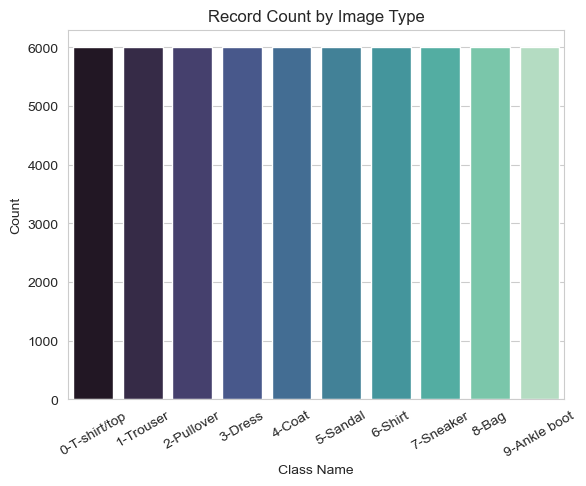

In [8]:
#exploratory data analysis: plot the distribution of class types
sb.set_style('whitegrid')
classdist=sb.countplot(data=new_df, x='new_label',palette = "mako")

plt.title('Record Count by Image Type')
plt.ylabel('Count')
plt.xlabel('Class Name')
plt.xticks(rotation = 30)
plt.show()

### Model and Analysis

In [9]:
#save label and pixel columns to new variables
pixels = new_df.iloc[:,1:785]
labels = new_df['label']

In [10]:
print(set(labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [11]:
## Create train and test data using these dataframes and labels
from sklearn.model_selection import train_test_split
TrainDF, TestDF, TrainLabels, TestLabels = train_test_split(pixels, labels, test_size=0.33,random_state =10, stratify = labels)


In [12]:
#check distributions in training and test sets
print(TrainLabels.value_counts())
print(TestLabels.value_counts())

1    4020
9    4020
3    4020
0    4020
4    4020
6    4020
5    4020
2    4020
7    4020
8    4020
Name: label, dtype: int64
2    1980
5    1980
0    1980
4    1980
3    1980
1    1980
8    1980
6    1980
9    1980
7    1980
Name: label, dtype: int64


In [13]:
print(TrainDF)

       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
14061       0       0       0       0       0       0       0       0       1   
12025       0       0       0       0       0       0       0       0       0   
52806       0       0       0       0       0       0       0       0       0   
42589       0       0       0       0       0       0       0       0       0   
56767       0       0       0       0       1       0       0       0      34   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
51623       0       0       0       0       0       0       0       0       0   
59995       0       0       0       0       0       0       0       0       0   
48271       0       0       0       0       0       0       1       0       0   
6347        0       0       0       0       0       0       0       0       0   
34492       0       0       0       0       0       0       0       0       0   

       pixel10  ...  pixel7

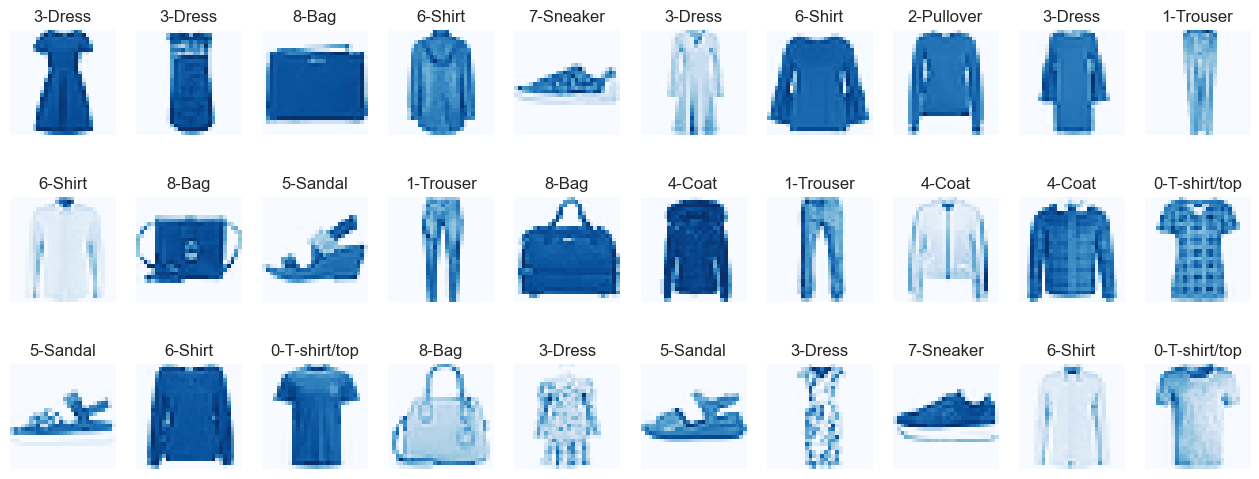

In [14]:
#Reference https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide
w_grid = 10
l_grid = 3

fig, axes = plt.subplots(l_grid, w_grid, figsize = (16,6))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_train = len(TrainDF) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, w_grid * l_grid): # create evenly spaces variables 

    # Select a random number
    np.random.seed(i) #set seed so that the results can be reproduced
    index = np.random.randint(0, n_train)

    # read and display an image with the selected index    
    axes[i].imshow(TrainDF.iloc[index,0:].array.reshape((28,28)), cmap='Blues')
    labelindex = int(TrainLabels.iloc[index])
    axes[i].set_title(f"{labelindex}-{class_names[labelindex]}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

In [15]:
# Scale images to the [0, 1] range
TrainDF = TrainDF / 255
TestDF = TestDF / 255

In [16]:
print(TrainDF.shape[0])

40200


#### Naive Bayes

In [45]:
%%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

#using 3-fold cv to find the best model
kFolds = 3
NB = MultinomialNB()
distributions = dict(alpha=list(np.arange(0.05,3.0,0.05)))
MNB = RandomizedSearchCV(NB, distributions, cv=kFolds, random_state = 10)
search = MNB.fit(TrainDF, TrainLabels)
print(search.best_params_)
print(search.best_score_)

{'alpha': 0.2}
0.6659203980099502
CPU times: user 19.3 s, sys: 4.21 s, total: 23.5 s
Wall time: 3.17 s


In [46]:
#make prediction using the best model found above
Prediction1 = search.predict(TestDF)
print((search.predict_proba(TestDF),2))

(array([[3.73450880e-029, 9.79468235e-092, 9.46943564e-001, ...,
        3.53729631e-256, 2.76684139e-039, 3.02081260e-135],
       [1.00498908e-037, 1.30898554e-062, 6.01009987e-018, ...,
        5.78606308e-001, 1.44534171e-007, 8.35980979e-002],
       [1.00000000e+000, 1.26142844e-050, 9.16608253e-021, ...,
        3.31023983e-322, 6.59524633e-054, 3.25337503e-170],
       ...,
       [5.13108079e-032, 2.22316807e-069, 2.19022140e-001, ...,
        3.79083868e-122, 6.92806987e-017, 3.51433827e-067],
       [3.15845856e-009, 3.60882371e-032, 7.11912037e-003, ...,
        5.92559791e-118, 1.96348703e-021, 4.58097808e-056],
       [1.95243893e-033, 1.41464916e-067, 1.58740042e-022, ...,
        3.86572317e-022, 3.31326239e-009, 7.10806927e-001]]), 2)


In [47]:
from sklearn.metrics import confusion_matrix
print("\nThe confusion matrix using Multinomimal Naive Bayes:")
print('\n')
print(pd.crosstab(TestLabels, Prediction1, rownames=['Actual'], colnames=['Predicted'], margins=True))


The confusion matrix using Multinomimal Naive Bayes:


Predicted     0     1     2     3     4    5    6     7     8     9    All
Actual                                                                    
0          1546     2    18   248     8    0  129     0    29     0   1980
1            24  1759    20   137     9    0   27     0     4     0   1980
2            13     1  1174    22   537    0  189     0    44     0   1980
3            74    29     3  1737    37    0   98     0     2     0   1980
4             4     4   351   283  1243    0   74     0    21     0   1980
5             2     0     3     3     1  307   12  1029    12   611   1980
6           448     2   294   155   703    0  296     0    81     1   1980
7             0     0     0     0     0   42    0  1836     2   100   1980
8            12     1     5    98   163    6   85    18  1592     0   1980
9             0     0     3     0     1   84   25   215     0  1652   1980
All        2123  1798  1871  2683  2702  439

In [48]:
from sklearn.metrics import classification_report

#check confusion matrix
print(classification_report(TestLabels, Prediction1))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      1980
           1       0.98      0.89      0.93      1980
           2       0.63      0.59      0.61      1980
           3       0.65      0.88      0.75      1980
           4       0.46      0.63      0.53      1980
           5       0.70      0.16      0.25      1980
           6       0.32      0.15      0.20      1980
           7       0.59      0.93      0.72      1980
           8       0.89      0.80      0.85      1980
           9       0.70      0.83      0.76      1980

    accuracy                           0.66     19800
   macro avg       0.66      0.66      0.64     19800
weighted avg       0.66      0.66      0.64     19800



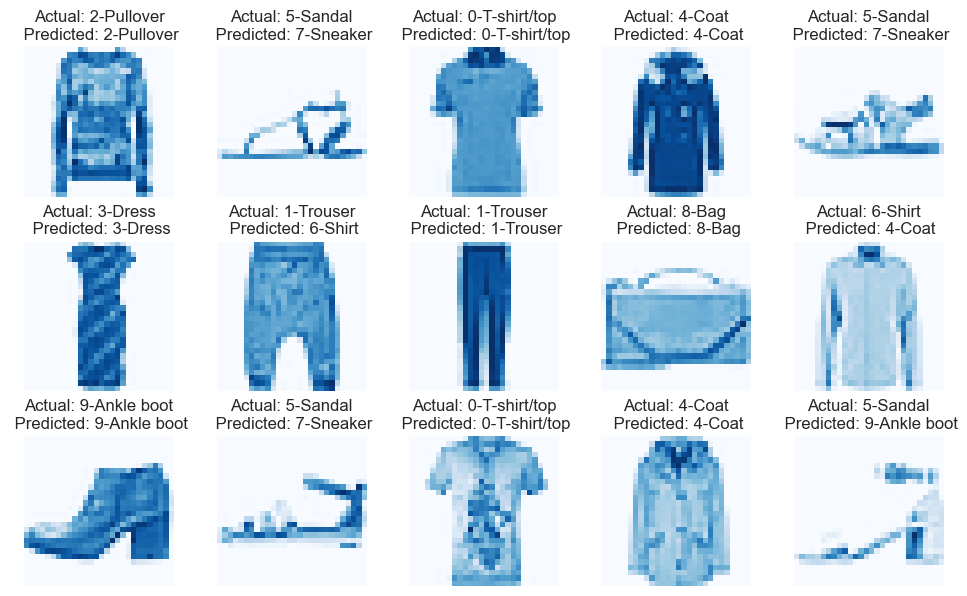

In [79]:
#visualize the test data with actual and predicted labels
w_grid = 5
l_grid = 3

fig, axes = plt.subplots(l_grid, w_grid, figsize = (12,7))
axes = axes.ravel() # flaten the matrix into array

# show the first 50 records in test data
for i in np.arange(0, w_grid * l_grid): # create evenly spaces variables 

    # read and display an image with the selected index    
    axes[i].imshow(TestDF.iloc[i].array.reshape((28,28)),cmap='Blues')
    axes[i].set_title(f"Actual: {TestLabels.iloc[i]}-{class_names[TestLabels.iloc[i]]}\n Predicted: {Prediction1[i]}-{class_names[Prediction1[i]]}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

#### Boosted Trees

In [52]:
%%time

from sklearn.ensemble import HistGradientBoostingClassifier

kFolds = 3
boosted = HistGradientBoostingClassifier(random_state=10)
distributions = dict(learning_rate=[0.01,0.05,0.1,0.15])
boosted_clf = GridSearchCV(boosted, distributions, cv=kFolds)
search2 = boosted_clf.fit(TrainDF, TrainLabels)
print(search2.best_params_)

{'learning_rate': 0.1}
CPU times: user 1h 20min 28s, sys: 7min 13s, total: 1h 27min 42s
Wall time: 12min 57s


In [53]:
print(search2.best_score_)

0.8910199004975125


In [54]:
#make prediction
Prediction2 = search2.predict(TestDF)

In [57]:
print("\nThe confusion matrix using Histogram-based Gradient Boosting Classification Tree  Model:")
print('\n')
print(pd.crosstab(TestLabels, Prediction2, rownames=['Actual'], colnames=['Predicted'], margins=True))


The confusion matrix using Histogram-based Gradient Boosting Classification Tree  Model:


Predicted     0     1     2     3     4     5     6     7     8     9    All
Actual                                                                      
0          1718     1    27    42     6     0   177     0     9     0   1980
1             7  1907     9    41     3     0    10     0     3     0   1980
2            28     0  1648    12   167     0   120     0     5     0   1980
3            43     5    10  1803    59     0    57     0     3     0   1980
4             4     1   146    68  1657     0   101     0     3     0   1980
5             0     0     1     1     0  1927     0    33     1    17   1980
6           277     0   196    42   154     0  1292     0    19     0   1980
7             0     0     0     0     0    18     0  1911     1    50   1980
8             3     0     4     9    14     3    32     4  1908     3   1980
9             0     0     1     1     0    10     0    57    

In [56]:
#check confusion matrix
print(classification_report(TestLabels, Prediction2))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1980
           1       1.00      0.96      0.98      1980
           2       0.81      0.83      0.82      1980
           3       0.89      0.91      0.90      1980
           4       0.80      0.84      0.82      1980
           5       0.98      0.97      0.98      1980
           6       0.72      0.65      0.69      1980
           7       0.95      0.97      0.96      1980
           8       0.98      0.96      0.97      1980
           9       0.96      0.96      0.96      1980

    accuracy                           0.89     19800
   macro avg       0.89      0.89      0.89     19800
weighted avg       0.89      0.89      0.89     19800



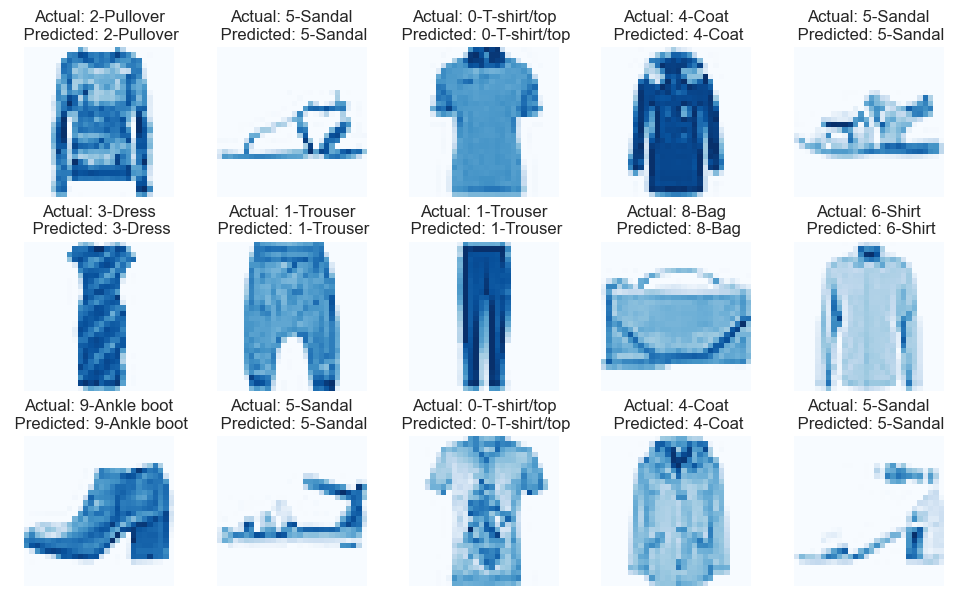

In [80]:
#visualize the test data with actual and predicted labels
w_grid = 5
l_grid = 3

fig, axes = plt.subplots(l_grid, w_grid, figsize = (12,7))
axes = axes.ravel() # flaten the matrix into array

# show the first 50 records in test data
for i in np.arange(0, w_grid * l_grid): # create evenly spaces variables 

    # read and display an image with the selected index  
    axes[i].imshow(TestDF.iloc[i].array.reshape((28,28)),cmap='Blues')
    axes[i].set_title(f"Actual: {TestLabels.iloc[i]}-{class_names[TestLabels.iloc[i]]}\n Predicted: {Prediction2[i]}-{class_names[Prediction2[i]]}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

#### Keras - CNN

In [30]:
# Model / data parameters
num_classes = 10

# reshape dataframes 
TrainDF_new = TrainDF.values.reshape(TrainDF.shape[0],28,28)
TestDF_new = TestDF.values.reshape(TestDF.shape[0],28,28)

# Make sure images have shape (28, 28, 1)
TrainDF_new = np.expand_dims(TrainDF_new, -1)
TestDF_new = np.expand_dims(TestDF_new, -1)

print("TrainDF_new shape:", TrainDF_new.shape)
print(TrainDF_new.shape[0], "train samples")
print(TestDF_new.shape[0], "test samples")

TrainDF_new shape: (40200, 28, 28, 1)
40200 train samples
19800 test samples


In [31]:
# convert class vectors to binary class matrices
TrainLabels_new = keras.utils.to_categorical(TrainLabels, num_classes)
TestLabels_new = keras.utils.to_categorical(TestLabels, num_classes)

In [32]:
# create the model
# Reference: https://keras.io/examples/vision/mnist_convnet/
input_shape = (28,28,1)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4), #randomly exclude a portion of data to minimize overfitting
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)             

In [33]:
%%time
#fit model using training data
batch_size = 128
epochs = 25

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

results = model.fit(TrainDF_new, TrainLabels_new, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/25
283/283 [==============================] - 11s 37ms/step - loss: 0.6647 - accuracy: 0.7605 - val_loss: 0.4438 - val_accuracy: 0.8470
Epoch 2/25
283/283 [==============================] - 11s 38ms/step - loss: 0.4268 - accuracy: 0.8469 - val_loss: 0.3805 - val_accuracy: 0.8701
Epoch 3/25
283/283 [==============================] - 10s 37ms/step - loss: 0.3748 - accuracy: 0.8671 - val_loss: 0.3708 - val_accuracy: 0.8600
Epoch 4/25
283/283 [==============================] - 11s 37ms/step - loss: 0.3505 - accuracy: 0.8753 - val_loss: 0.3323 - val_accuracy: 0.8808
Epoch 5/25
283/283 [==============================] - 10s 37ms/step - loss: 0.3288 - accuracy: 0.8816 - val_loss: 0.3102 - val_accuracy: 0.8915
Epoch 6/25
283/283 [==============================] - 10s 37ms/step - loss: 0.3097 - accuracy: 0.8913 - val_loss: 0.2923 - val_accuracy: 0.9002
Epoch 7/25
283/283 [==============================] - 11s 37ms/step - loss: 0.2953 - accuracy: 0.8929 - val_loss: 0.2864 - val_accuracy:

In [34]:
#check history of the model
print(results.history)

{'loss': [0.6647282242774963, 0.4267699420452118, 0.3748413622379303, 0.35052329301834106, 0.3288465738296509, 0.30973777174949646, 0.29532235860824585, 0.2839776277542114, 0.2775918245315552, 0.2670232951641083, 0.26034483313560486, 0.249432772397995, 0.2411109358072281, 0.2367877960205078, 0.22890736162662506, 0.2237602174282074, 0.21737349033355713, 0.21646389365196228, 0.20755019783973694, 0.2054714411497116, 0.19894346594810486, 0.19394226372241974, 0.19239039719104767, 0.18694819509983063, 0.18623991310596466], 'accuracy': [0.7605030536651611, 0.8468767404556274, 0.867136538028717, 0.8753178715705872, 0.8816196918487549, 0.891265869140625, 0.8928966522216797, 0.8988391160964966, 0.9005804061889648, 0.9056661128997803, 0.9061912894248962, 0.9104753732681274, 0.913405179977417, 0.9154781699180603, 0.9179933667182922, 0.9194029569625854, 0.9213930368423462, 0.9213377833366394, 0.9252902269363403, 0.9267827272415161, 0.9271144270896912, 0.9299336671829224, 0.9295743703842163, 0.93159

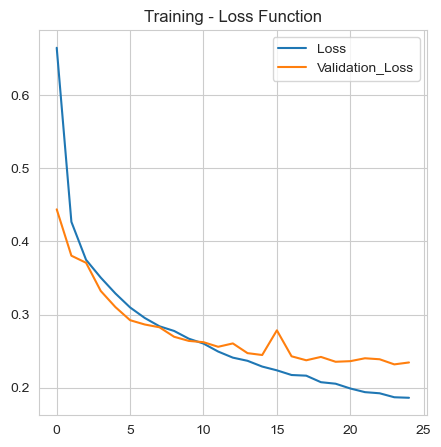

In [35]:
# Line plots of results
sb.set_style('whitegrid')
plt.figure(figsize=(5, 5))
plt.plot(results.history['loss'], label='Loss')
plt.plot(results.history['val_loss'], label='Validation_Loss')
plt.title('Training - Loss Function')
plt.legend()
plt.show()

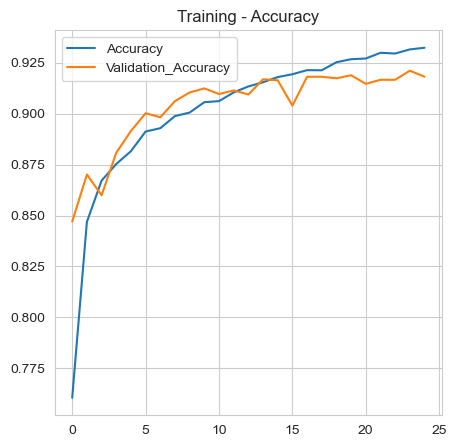

In [36]:
# Line plots of results
sb.set_style('whitegrid')
plt.figure(figsize=(5, 5))
plt.plot(results.history['accuracy'], label='Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation_Accuracy')
plt.title('Training - Accuracy')
plt.legend()
plt.show()

In [37]:
#evaluate the model on test data
score = model.evaluate(TestDF_new, TestLabels_new, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.23531165719032288
Test accuracy: 0.9160100817680359


In [38]:
#make predictions on test data
Prediction3 = model.predict(TestDF_new)
Prediction3 =np.argmax(Prediction3,axis=1)

619/619 [==============================] - 2s 4ms/step


In [39]:
print(Prediction3)

[2 5 0 ... 4 2 5]


In [40]:
print("\nThe confusion matrix using Keras CNN Model:")
print('\n')
print(pd.crosstab(TestLabels, Prediction3, rownames=['Actual'], colnames=['Predicted'], margins=True))


The confusion matrix using Keras CNN Model:


Predicted     0     1     2     3     4     5     6     7     8     9    All
Actual                                                                      
0          1616     4    41    47     7     1   256     0     8     0   1980
1             0  1952     1    19     2     0     5     0     1     0   1980
2            20     0  1678    18   159     0   102     0     3     0   1980
3            14    20     9  1835    44     0    56     0     1     1   1980
4             2     2    71    73  1752     0    79     0     1     0   1980
5             0     1     0     0     0  1940     0    23     3    13   1980
6           120     1    95    53   117     1  1578     0    15     0   1980
7             0     0     0     0     0    11     0  1949     0    20   1980
8             3     2     1     8     7     2    12     5  1939     1   1980
9             0     0     0     1     1     9     0    71     0  1898   1980
All        1775  1982  1896  

In [41]:
#check confusion matrix
print(classification_report(TestLabels, Prediction3))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1980
           1       0.98      0.99      0.99      1980
           2       0.89      0.85      0.87      1980
           3       0.89      0.93      0.91      1980
           4       0.84      0.88      0.86      1980
           5       0.99      0.98      0.98      1980
           6       0.76      0.80      0.78      1980
           7       0.95      0.98      0.97      1980
           8       0.98      0.98      0.98      1980
           9       0.98      0.96      0.97      1980

    accuracy                           0.92     19800
   macro avg       0.92      0.92      0.92     19800
weighted avg       0.92      0.92      0.92     19800



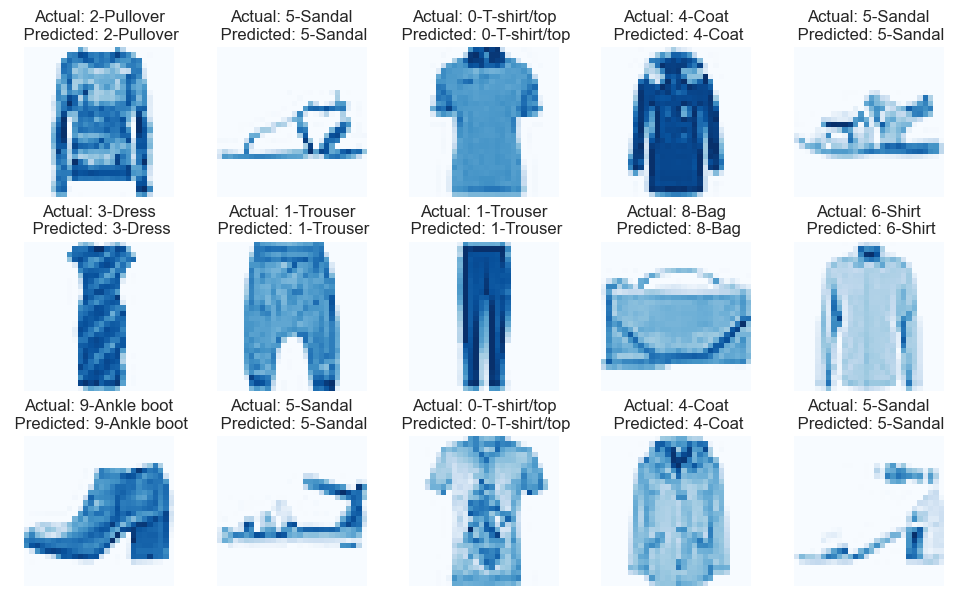

In [42]:
#visualize the test data with actual and predicted labels
w_grid = 5
l_grid = 3

fig, axes = plt.subplots(l_grid, w_grid, figsize = (12,7))
axes = axes.ravel() # flaten the matrix into array

# show the first 50 records in test data
for i in np.arange(0, w_grid * l_grid): # create evenly spaces variables 

    # read and display an image with the selected index  
    axes[i].imshow(TestDF.iloc[i].array.reshape((28,28)),cmap='Blues')
    axes[i].set_title(f"Actual: {TestLabels.iloc[i]}-{class_names[TestLabels.iloc[i]]}\n Predicted: {Prediction3[i]}-{class_names[Prediction3[i]]}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

### Conclusion
  The Multinomial Naïve Bayes model had the shortest train time but also performed much worse than the other two models. Convolutional Neural Network requested more complicated data preprocessing steps and longer model train time, but it had the highest overall accuracy, precision, recall and f1-score when applied to the test data set. 
  The Histogram-based Gradient Boosting Tree model was also very easy to build, and its results were only slightly worse than Convolutional Neural Network. If we know the best parameter values to be used for the Histogram-based Gradient Boosting Tree model, it will take shorter time to train comparing to Convolutional Neural Network. However, if we take into consideration of the time used for parameter tuning, the Convolutional Neural Network is more efficient and will take less time.
  Overall, Convolutional Neural Network works the best for fashion image classification among three algorithms used in this report.